We would be doing clustering and cluster analysis of the yeast dataset downloaded from UC Irvine Machine Learning Repository

Link to dataset: https://archive.ics.uci.edu/dataset/110/yeast

Dataset citation: Nakai,Kenta. (1996). Yeast. UCI Machine Learning Repository. https://doi.org/10.24432/C5KG68.

In [73]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

yeast_df = pd.read_csv("data/yeast.csv")
yeast_df.shape

(1484, 10)

In [74]:
yeast_df.sample(5, random_state=0)

,seq_name,mcg,gvh,alm,mit,erl,pox,vac,nuc,loc_site
9,ABP1_YEAST,0.40,0.39,0.60,0.15,0.5,0.0,0.58,0.30,CYT
342,GAL7_YEAST,0.50,0.50,0.48,0.17,0.5,0.0,0.47,0.26,CYT
676,NCPR_YEAST,0.78,0.63,0.53,0.13,0.5,0.0,0.54,0.22,ME2
1288,TRK2_YEAST,0.59,0.48,0.41,0.53,0.5,0.0,0.48,0.56,ME3
1243,EF1A_YEAST,0.63,0.43,0.48,0.11,0.5,0.0,0.51,0.22,CYT


In [75]:
yeast_df.isnull().sum()


seq_name    0
mcg         0
gvh         0
alm         0
mit         0
erl         0
pox         0
vac         0
nuc         0
loc_site    0
dtype: int64

In [76]:
yeast_df.dtypes

seq_name     object
mcg         float64
gvh         float64
alm         float64
mit         float64
erl         float64
pox         float64
vac         float64
nuc         float64
loc_site     object
dtype: object

In [77]:
yeast_df.dtypes

seq_name     object
mcg         float64
gvh         float64
alm         float64
mit         float64
erl         float64
pox         float64
vac         float64
nuc         float64
loc_site     object
dtype: object

In [78]:
yeast_df["seq_name"] = LabelEncoder().fit_transform(yeast_df["seq_name"])

In [79]:
yeast_df["loc_site"].nunique()

10

In [80]:
yeast_df["loc_site"].value_counts()

loc_site
CYT    463
NUC    429
MIT    244
ME3    163
ME2     51
ME1     44
EXC     35
VAC     30
POX     20
ERL      5
Name: count, dtype: int64

In [81]:
yeast_df["loc_site"] = yeast_df["loc_site"].apply(lambda x: x if x in ["CYT", "NUC", "MIT", "ME3"] else "Other")
yeast_df["loc_site"].value_counts()

loc_site
CYT      463
NUC      429
MIT      244
Other    185
ME3      163
Name: count, dtype: int64

In [82]:
labels = yeast_df["loc_site"]
yeast_without_label_df = yeast_df.drop("loc_site", axis=1)
yeast_without_label_df.columns

Index(['seq_name', 'mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc'], dtype='object')

Now after doing some basic EDA we would apply PCA on the unlabelled dataset to allow visualization of the results

In [83]:
from sklearn.decomposition import PCA
pca = PCA(2, random_state=0)
yeast_without_label_df_pca = pca.fit_transform(yeast_without_label_df)
yeast_without_label_df_pca.shape

(1484, 2)

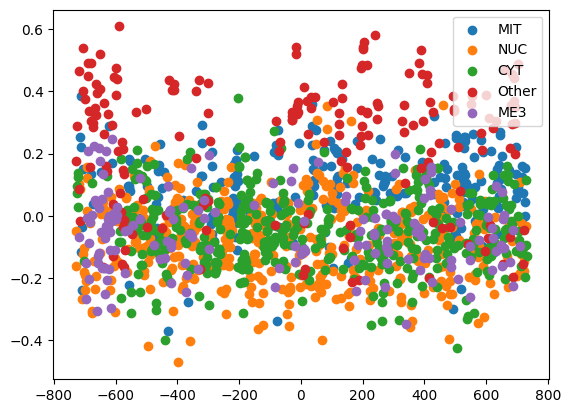

In [84]:
from matplotlib import pyplot as plt

for i in labels.unique():
    plt.scatter(yeast_without_label_df_pca[labels == i , 0] , yeast_without_label_df_pca[labels == i , 1] , label = i)
plt.legend()
plt.show()

Now let's apply K-Means clustering and see what results are produced

In [85]:
from sklearn.cluster import KMeans
 
kmeans = KMeans(n_clusters= 5, random_state=0)
yeast_df["pred_loc_site"] = kmeans.fit_predict(yeast_without_label_df)
pred_labels = yeast_df["pred_loc_site"]

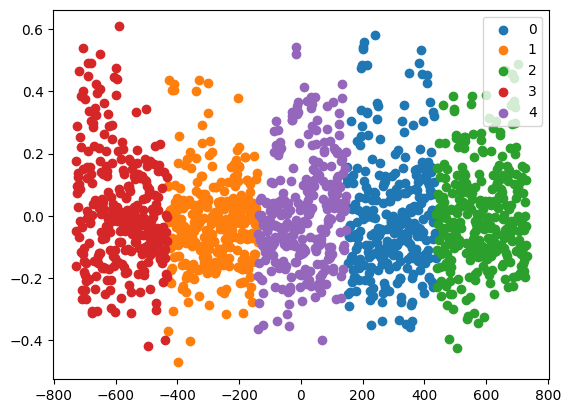

In [86]:
import numpy as np

for i in np.unique(pred_labels):
    plt.scatter(yeast_without_label_df_pca[pred_labels == i , 0] , yeast_without_label_df_pca[pred_labels == i , 1] , label = i)
plt.legend()
plt.show()

We can see that the cluster produced are far away from the original distribution of the data

Let's find a way to alter our data which may produce better results on clustering

In [87]:
yeast_df["seq_name"].nunique()

1462

We have observed that the sequence name column has almost the same number of unique values as data points, due to which we can say that this column maybe the reason of our clusters being formed parallel to each other

Let's drop this column and then see the results

In [88]:
yeast_without_label_df = yeast_without_label_df.drop("seq_name", axis=1)

In [89]:
yeast_without_label_df_pca = pca.fit_transform(yeast_without_label_df)
yeast_without_label_df_pca.shape

(1484, 2)

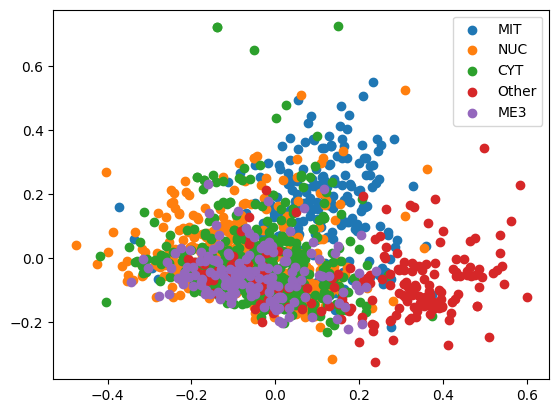

In [90]:
for i in labels.unique():
    plt.scatter(yeast_without_label_df_pca[labels == i , 0] , yeast_without_label_df_pca[labels == i , 1] , label = i)
plt.legend()
plt.show()

In [91]:
yeast_df["pred_loc_site"] = kmeans.fit_predict(yeast_without_label_df)
pred_labels = yeast_df["pred_loc_site"]

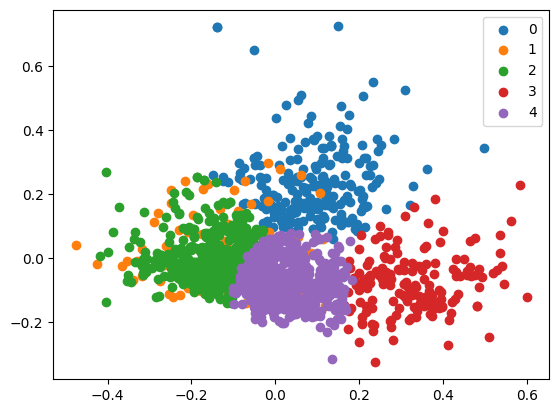

In [92]:
for i in np.unique(pred_labels):
    plt.scatter(yeast_without_label_df_pca[pred_labels == i , 0] , yeast_without_label_df_pca[pred_labels == i , 1] , label = i)
plt.legend()
plt.show()

we can see that the results of clustering has improved drastically but it still is not upto the mark as the original data points overlap.

Let's calculate entropy and purity of our clusters.

In [93]:
from scipy.stats import entropy

overall_entropy = 0
for i in sorted(pred_labels.unique()):
    _, counts = np.unique(yeast_df[pred_labels == i]["loc_site"], return_counts=True)
    cluster_entropy =  entropy(counts, base=2)
    print(f"Entropy of cluster {i}: {cluster_entropy}")
    overall_entropy += (cluster_entropy * len(yeast_df[pred_labels == i].index)/len(yeast_df.index))

print(f"\nOverall entropy: {overall_entropy}")

Entropy of cluster 0: 1.507188725310146
Entropy of cluster 1: 1.2543078658189297
Entropy of cluster 2: 1.936377965121798
Entropy of cluster 3: 1.2801412488144495
Entropy of cluster 4: 2.007529574635004

Overall entropy: 1.7633033230606998


In [94]:
overall_purity = 0
for i in sorted(pred_labels.unique()):
    _, counts = np.unique(yeast_df[pred_labels == i]["loc_site"], return_counts=True)
    cluster_purity =  max(counts)/len(yeast_df[pred_labels == i].index)
    print(f"Purity of cluster {i}: {cluster_purity}")
    overall_purity += (cluster_purity * len(yeast_df[pred_labels == i].index)/len(yeast_df.index))

print(f"\nOverall purity: {overall_purity}")

Purity of cluster 0: 0.6238938053097345
Purity of cluster 1: 0.6825396825396826
Purity of cluster 2: 0.37020316027088035
Purity of cluster 3: 0.7455621301775148
Purity of cluster 4: 0.42115384615384616

Overall purity: 0.49595687331536387


We can see that the clusters produced by our algorithm have high entropy and low purity which indicates that the clustering performed wasn't ideal.

Now let's calculate cohesion and seperation metrics for our clusters.

In [101]:
from scipy.spatial.distance import pdist

for i in sorted(pred_labels.unique()):
    avg_pdist = np.average(pdist(yeast_without_label_df[pred_labels == i]))
    print(f"Average pairwise distance of cluster {i}: {avg_pdist}")

Average pairwise distance of cluster 0: 0.2809251710166594
Average pairwise distance of cluster 1: 0.3050387293603183
Average pairwise distance of cluster 2: 0.2556463920871384
Average pairwise distance of cluster 3: 0.2973171942255081
Average pairwise distance of cluster 4: 0.24277505989660816


In [102]:
avg_pdist_centroids = np.average(pdist(kmeans.cluster_centers_))
print(f"Average seperation between cluster centroids: {avg_pdist_centroids}")

Average seperation between cluster centroids: 0.3625271316584475


In [106]:
from sklearn.metrics import silhouette_score
encoded_labels = LabelEncoder().fit_transform(labels).reshape(-1, 1)
silhouette = silhouette_score(encoded_labels, pred_labels)
print(f"Silhouette score: {silhouette}")

Silhouette score: -0.08660988396560156


The scores produced above further strengthens our claim that the clustering wasn't ideal as average pairwise distance between centroids is close to average pairwise distance within the cluster. Also the silhoutte score is < 0 which indicates bad clustering.